# CEB 35300, Phylogenetic Comparative Methods 
## University of Chicago, 2018<br>Andrew Hipp, ahipp@mortonarb.org
### Session 1b: Visualizing phylogenetic and comparative data in R

In this session, we'll focus on how to visualize phylogenetic data in R. There are several packages available to explore phylogenetic data in R. I'll focus on just a few here:
* __ape__ is the most well developed package for importing and manipulating phylogenetic data, and also the oldest. I find that the plotting functions in this package are the most flexible, readily adapted to whatever I want to do with my data. You can follow the development of this package and get the latest version prior to release on CRAN at Emmanuel Paradis's website (http://ape-package.ird.fr/).
* __ggtree__ is a relative newcomer, built as an extension of the elegant `ggplot2` package. I don't find this package as flexible as `ape`, but this is almost certainly at least in part because I am not adept with `ggplot2`. Some of the canned functions are nice and well worth exploring. Take a look at the documentation on the website for examples of what it can do (https://bioconductor.org/packages/release/bioc/html/ggtree.html).
* __phytools__ has a few exceptionally nice built-in visualizations. We'll only look at a few here, but you are encouraged to explore the package more both directly through its built-in documentation as well as through the developer Liam Revell's blog (http://blog.phytools.org/), in which Liam explores questions tossed his way by hungry phylogeny enthusiasts and issues he is interested in pursuing on his own. There is _so_ much fascinating stuff in this blog... I encourage you to follow it.

Beyond these, you can find a great introduction to the wealth of phylogenetic tools in R on Brian O'Meara's encyclopedic CRAN Task View for Phylogenetics (https://cran.r-project.org/web/views/Phylogenetics.html), a topically-organized pointer to more packages than you can imagine. How does Brian keep up with them all? It is truly remarkable.

Because there is so much great work on visualization of phylogenies in R, there is also a lot of good documentation. My goals for this session will thus not be to march you through all the possibilities, but rather to:
1. Introduce you to the structure of tree objects in R
2. Show you how to extraction information on tree plots and plot your own data directly, introducing some of hte methods by which you can create custom plots in R
3. Introduce a few visualizations that I use very often to see what my data look like, with the expectation that you will want to be able to look at your data when you are analyzing to see if the conclusions you are coming to make sense and to tell a compelling story about your conclusions as they begin to roll in.

Let's begin by creating a new workspace for ourself and importing our data from last time. We took care to get this data in order in the last session, and we'll use it over and over in these tutorials:

In [1]:
setwd('PCM2018-tutorials')
dir.create('tutorial.02') # create a directory for the next tutorial
setwd('tutorial.02')
dir.create('workspace') # create our new workspace
setwd('workspace') # move into the new workspace
load('../../PCM.session01a.Rdata') # load data from last tutorial
print(ls()) # show what objects are here to confirm that we have the objects we need

 [1] "dat.bio"       "dat.bio.bySp"  "dat.bio.means" "dat.bio.sem"  
 [5] "dat.geog"      "dat.lf"        "dat.sections"  "numCols"      
 [9] "spp.intersect" "tr"           


Now we'll attach three libraries that we'll be using in this tutorial:

In [4]:
library(ape)
library(ggtree)
library(phytools)

### 1. Structure of the `phylo` object
The `ape` package introduced the `phylo` class to represent trees. Trees are stored differently in R than in pointer-based languages. If you are used to `C++` or `Java`, you probably expect trees to be stored as a series of nodes that point to each other and are readily traversed recursively. In `R`, which is not object-oriented in the same sense as these other languages, Emmanuel Paradis early on settled on a list structure that has three key components. To see them, let's first make a small random tree and plot it:

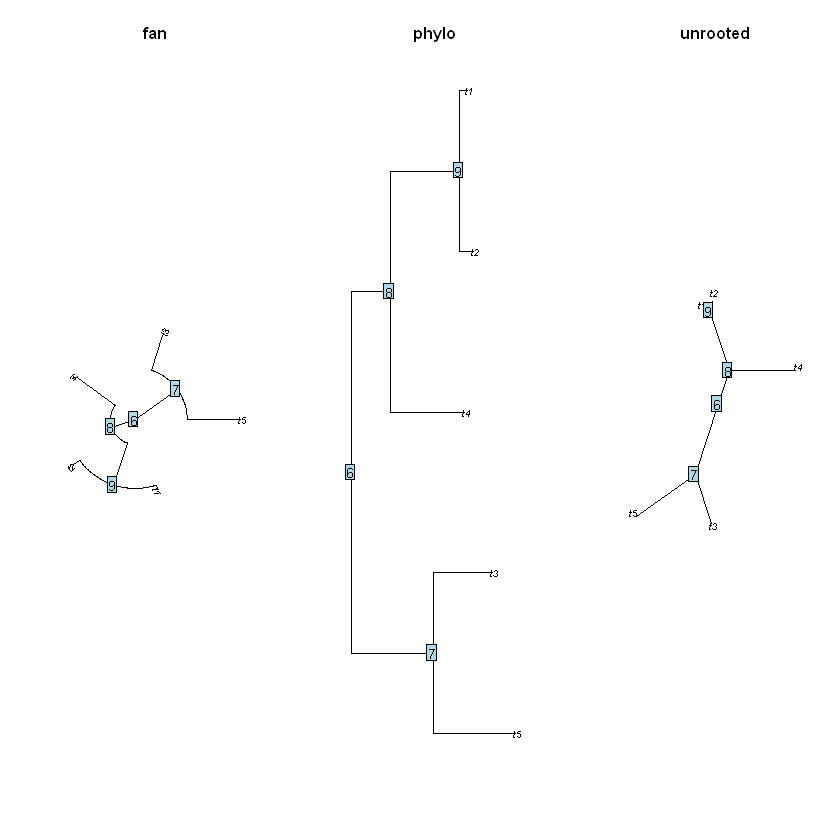

In [5]:
babyTree <- rtree(5) # creates a random tree with 5 tips
par(mfcol = c(1,3))
#layout(matrix(1:3, 1))
for(trType in c('fan', 'phylo', 'unrooted')) {
    plot(babyTree, trType, main = trType)
    nodelabels()
}

The nodes numbered above are the actual node numbers used internally, and you can use them to plot at the nodes, to access descendants, and to find branch lengths of branches above and below. Branches then are defined by nodes at each end: 

In [6]:
print(babyTree$edge)

     [,1] [,2]
[1,]    6    7
[2,]    7    1
[3,]    7    2
[4,]    6    8
[5,]    8    3
[6,]    8    9
[7,]    9    4
[8,]    9    5


In the matrix above, you can see that each edge has an ancestor node (first column) and a descendent node (second column). Compare the matrix with the tree plotted above to see how this works. Every node or tip shows up only once as a descendant, but each node can be ancestor to two or more descendants. Thus, I can find the descendants of any given node; for example, for node 6:

> `babyTree$edge[which(babyTree$edge[,1] == 6), 2]`

Note that nodes 1 through the number of tips on the tree 

> `1:length(babyTree$tip.label)`

are the tips of the tree, and correspond to the tip labels in order above. Compare these node numbers with the tip labels below, which are indexed by the numbers:

In [7]:
print(babyTree$tip.label)

[1] "t5" "t3" "t4" "t2" "t1"


Finally, the phylo object gives the length for each edge:

In [8]:
print(round(babyTree$edge.length, 4))

[1] 0.9597 0.9367 0.6629 0.4539 0.8488 0.8156 0.1327 0.0607


The edge matrix alone defines the branching structure. However, every `phylo` tree is required to have at least three elements: `edge`, `tip.label`, and `Nnode`, an integer telling how many nodes are in the tree. The vector `edge.length` is optional from R's standpoint, but as you probably already know, it is far from optional from a statistical and biological standpoint: almost every analysis we do in this course will use branch lengths as part of the model of character evolution.

There are many functions useful for manipulating trees. I won't go into details about how to use them, as each is well documented, but you should at least be familiar with these:

* __`drop.tip`__
* __`ladderize`__ # purely cosmetic, but nice if you are trying to put together a tree for publication
* __`root`__
* __`plot.phylo`__ 
* __`multi2di`__ makes a tree fully dichotomous, required for some functions

Finally, and perhaps more usefully, you can find the most recent common ancestor of any two tips using the `mrca` or `getMRCA` function in ape; and the nodes and tips that are descendants of a given node, using `Descendants` from the Phangorn package or `getDescendants` from the phytools package. I'll show an example below, in which we use these to paint the branches of a tree.

### Extract coordinates from a plotted tree so that you can directly annotate it
Exploring the options for tree plotting in __`ape`__ (use `?plot.phylo` to start, then search the entire index of ape by entering `?ape` and searching in your browser using ctrl-F), __`phytools`__ (again, enter `?phytools` and search the index using ctrl-F; also study [Liam Revell's blog](http://blog.phytools.org/)), __`ggtree`__ (documentation for this young package is not as well developed, but you can see nice examples on the package [website](https://bioconductor.org/packages/release/bioc/html/ggtree.html)) and other packages, you'll find a wealth of canned visualizations, many of them quite sophisticated. At times, however, you are going to want to either tweak a canned visualization or create your own. Your goal should be to translate your ideas into exactly the visualization you want, rather than using someone else's visualization, which will most likely only approximate what you want to show.

One of the keys to doing this is orienting yourself in space on an existing plot. Let's look at how you do this. When you plot a tree, you end up with an object called `last_plot.phylo` in the `.PlotPhyloEnv`. You can access this using `get('last_plot.phylo', envir = .PlotPhyloEnv)`. In that opjection you will find the plotting parameters and tree you plotted, which is handy. Better still, you'll find the limits of the plot (`x.lim` and `y.lim` respectively) and the x-y coordinates of each node (`xx` and `yy`). Hot dog! Let's take a look at how we could use these to annotate a tree with some real data.

#### Visualizing categorical data
First, let's try a simplistic example. Let's put points at the edge of our tree indicating for each tip whether it is a red oak, a white oak, or a golden-cupped oak. First, let's add a color column to our data frame that tells us which section each of our oak species is in:

In [9]:
print(unique(dat.sections$Section))
dat.sections$color <- NA
dat.sections$color[grep('Quercus', dat.sections$Section)] <- 'black'
dat.sections$color[dat.sections$Section == 'Virentes'] <- 'green'
dat.sections$color[dat.sections$Section == 'Sadlerianae'] <- 'blue'
dat.sections$color[dat.sections$Section == 'Protobalanus'] <- 'yellow'
dat.sections$color[dat.sections$Section == 'Lobatae'] <- 'red'

[1] "Quercus - American" "Quercus - Eurasian" "Virentes"          
[4] "Sadlerianae"        "Protobalanus"       "Lobatae"           


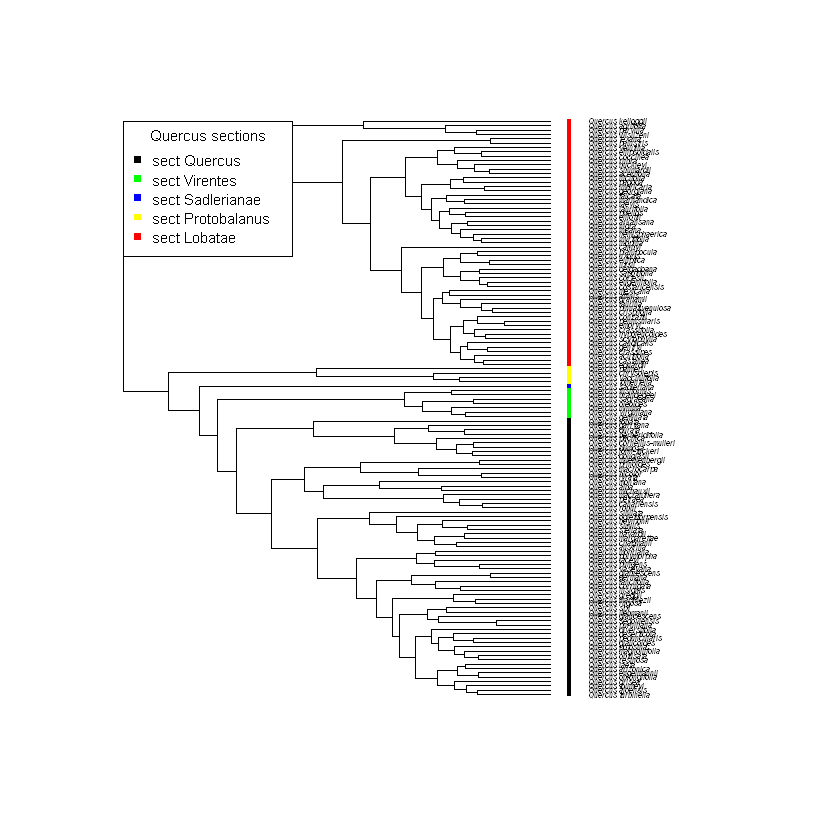

In [10]:
## plot the tree first:
plot(tr, show.tip.label = T, cex = 0.4, label.offset = 4)

## now, get the plotting parameters, stick them into an object pp:
pp <- get("last_plot.phylo", envir = .PlotPhyloEnv)

## now we'll plot the points at just the tips
points(pp$xx[1:length(tr$tip.label)] + 2, 
       pp$yy[1:length(tr$tip.label)], 
       pch = 15, # makes the plotting character a square
       cex = 0.5,
       col = dat.sections[tr$tip.label, 'color']) # orders the colors by the actual tip labels

## and we can add a legend, using the minimum and maximum values of x and y respectively:
legend(x = pp$x.lim[1], y = pp$y.lim[2], 
       legend = c('sect Quercus',
                 'sect Virentes',
                 'sect Sadlerianae',
                 'sect Protobalanus',
                 'sect Lobatae'), 
       pch = c(15),
       col = c('black', 'green', 'blue', 'yellow', 'red'), 
       cex = 0.75, pt.cex = 0.75, 
       title = "Quercus sections"
      )

#### Using information from the plot.phylo function to annotate a phylogeny with continuous trait data
You can go well beyond this... let's take a look at how you might use the coordinate data to visualize continuous traits. This example is a bit rudimentary, but it shows you how you can get into the tree structure to do what you want to:

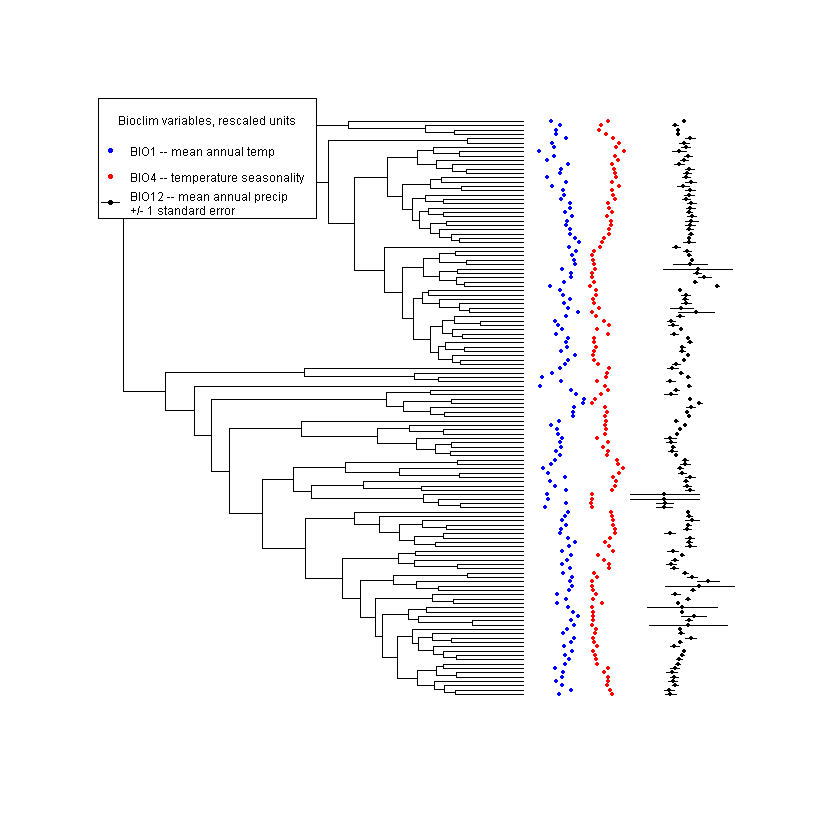

In [11]:
## first, let's plot the tree in white to just set the plotting parameters
plot(tr, show.tip.label = F, edge.color = 'white')

## then we'll grab those plotting parameters, as we did above
pp<-get("last_plot.phylo",envir=.PlotPhyloEnv)

## then we'll replot, setting the rightmost limit of the plot inward so that there is room for annotation on the right side
par(new = T) # this command overplots on the existing plot window rather than creating a new one
plot(tr, show.tip.label = F, x.lim = c(pp$x.lim[1], pp$x.lim[2] + 0.6 * abs(diff(pp$x.lim))))

## now let's plot three characters at different relative distances on the x scale, and in different colors
points(pp$xx[1:length(tr$tip.label)] + diff(pp$x.lim) * 0.1 + scale(dat.bio.means[tr$tip.label, 'bio1']),
       pp$yy[1:length(tr$tip.label)],
       pch = 19,
       cex = 0.4,
       col = 'blue'
       )
points(pp$xx[1:length(tr$tip.label)] + diff(pp$x.lim) * 0.2 + scale(dat.bio.means[tr$tip.label, 'bio4']),
       pp$yy[1:length(tr$tip.label)],
       pch = 19,
       cex = 0.4,
       col = 'red'
       )
points(pp$xx[1:length(tr$tip.label)] + diff(pp$x.lim) * 0.4 + scale(dat.bio.means[tr$tip.label, 'bio12']),
       pp$yy[1:length(tr$tip.label)],
       pch = 19,
       cex = 0.4,
       col = 'black'
       )

## and let's add the SEM to each of our bio12 points;
##   this is actually just a relative SEM, because it is rescaled to unit variance for visualization purposes
segments(x0 = pp$xx[1:length(tr$tip.label)] + diff(pp$x.lim) * 0.4 + 
         scale(dat.bio.means[tr$tip.label, 'bio12']) + 
         scale(dat.bio.sem[tr$tip.label, 'bio12']),
         y0 = pp$yy[1:length(tr$tip.label)],
         x1 = pp$xx[1:length(tr$tip.label)] + diff(pp$x.lim) * 0.4 + 
         scale(dat.bio.means[tr$tip.label, 'bio12']) - 
         scale(dat.bio.sem[tr$tip.label, 'bio12']),
         y1 = pp$yy[1:length(tr$tip.label)]
         )



## when you add the legend, points and lines and other symbols can be intermixed; 
##   just set NA for any that you don't want to show
legend("topleft", legend = c('BIO1 -- mean annual temp', 
                             'BIO4 -- temperature seasonality',
                            'BIO12 -- mean annual precip\n+/- 1 standard error'), 
       pch = c(19,19,19), 
       lty = c(NA,NA,'solid'),
       col = c('blue', 'red', 'black'), 
       cex = 0.6, pt.cex = 0.6, 
       title = "Bioclim variables, rescaled units",
       seg.len = 1.5
      )

#### Coloring branches based on clade identity
I promised you above that we'd look at an example that uses `mrca` and `getDescendants` to color branches, and this seems as nice a time as any. We'll stick with categorical data for now: let's paint a taxonomy onto a tree. Recall that we have a matrix `dat.sections` that tells us the taxonomy of our group. Let's first identify the unique names we care about:

In [12]:
dat.sect.vector <- unique(dat.sections$Section)
print(dat.sect.vector)

[1] "Quercus - American" "Quercus - Eurasian" "Virentes"          
[4] "Sadlerianae"        "Protobalanus"       "Lobatae"           


The section _Sadlerianae_ has only one tip in our tree, so we'll drop that one for now, using the `-` index to remove rather than select indexed elements of the vector:

In [13]:
dat.sect.vector <- dat.sect.vector[-c(4)]

Then, let's assign a color to each clade:

In [14]:
dat.sect.colors <- c('gray75', 'gray95', 'green', 'yellow', 'red')
names(dat.sect.colors) <- dat.sect.vector
print(dat.sect.colors)

Quercus - American Quercus - Eurasian           Virentes       Protobalanus 
          "gray75"           "gray95"            "green"           "yellow" 
           Lobatae 
             "red" 


Now we need to find the nodes for each of those clades. Let's use `sapply`, which we discussed in the last tutorial. We'll use it to pass a vector of tips for each clade into `getMRCA`:

In [15]:
dat.sect.mrca <- sapply(dat.sect.vector, function(x) {
    getMRCA(tr, row.names(dat.sections)[dat.sections$Section == x])
})
print(dat.sect.mrca)

Quercus - American Quercus - Eurasian           Virentes       Protobalanus 
               138                184                201                207 
           Lobatae 
               210 


Now we need to find the descendants of each node; this time we'll use `lapply`, because there is no simplification to be done: we want to keep each set of descendants as an element in a list. `sapply` would probably be just fine here, but there is always a risk that it would succeed in simplifying our list to a matrix or some such thing.

In [16]:
dat.sect.desc <- lapply(dat.sect.mrca, getDescendants, tree = tr)
print(dat.sect.desc)

$`Quercus - American`
  [1] 139 193 140 182 141 174 142 170 143 166 144 164 145 160 146 153 147 150
 [19] 148   4 149   3   1   2 151 152   5   6   7   8 154  16 155 158 156  12
 [37] 157  11   9  10 159  15  13  14 161 163 162  19  17  18  20  21 165  24
 [55]  22  23 167 169 168  27  25  26  28  29 171 173 172  32  30  31  33  34
 [73] 175  43 176  42 177 180 178 179  35  36  37  38 181  41  39  40 183 189
 [91] 184 187 185  47 186  46  44  45 188  50  48  49 190 192 191  53  51  52
[109]  54  55 194  64 195 199 196  60 197 198  56  57  58  59 200  63  61  62

$`Quercus - Eurasian`
[1] 185  47 186  46  44  45

$Virentes
 [1] 202 206 203 205 204  67  65  66  68  69  70  71

$Protobalanus
[1] 208  76 209  75  73  74

$Lobatae
  [1] 211 263 212 262 213 240 214 104 215 232 216 227 217 222 218 220 219  79
 [19]  77  78 221  82  80  81 223 225 224  85  83  84 226  88  86  87 228 231
 [37] 229  92 230  91  89  90  93  94 233 237 234 236 235  97  95  96  98  99
 [55] 238 239 100 101 102 103 

What we've got now is the _nodes_, but we want to color the branches. So for each node, let's get the edge that leads to it.

In [17]:
dat.sect.edges <- lapply(dat.sect.desc, function(x) which(tr$edge[, 2] %in% x))
print(dat.sect.edges)

$`Quercus - American`
  [1]   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22
 [19]  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
 [37]  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
 [55]  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
 [73]  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
 [91]  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
[109] 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130

$`Quercus - Eurasian`
[1] 94 95 96 97 98 99

$Virentes
 [1] 132 133 134 135 136 137 138 139 140 141 142 143

$Protobalanus
[1] 146 147 148 149 150 151

$Lobatae
  [1] 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 [19] 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 [37] 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 [55] 207 208 209 210 211 212 213 21

Okay! We're almost there. Let's make a vector of colors now:

In [18]:
dat.sect.colVect <- rep('black', dim(tr$edge)[1]) # a character as long as the first dimension of the edge matrix
for(i in names(dat.sect.edges)) { # set up a loop to run through the section names
    dat.sect.colVect[dat.sect.edges[[i]] ] <- # index dat.sect.colVect by the edges in element i of the dat.sect.edges list...
       dat.sect.colors[i] # ... and fill those elements with the appropriate color
} # close i
print(dat.sect.colVect)

  [1] "black"  "black"  "black"  "black"  "gray75" "gray75" "gray75" "gray75"
  [9] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [17] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [25] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [33] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [41] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [49] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [57] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [65] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [73] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [81] "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75" "gray75"
 [89] "gray75" "gray75" "gray75" "gray75" "gray75" "gray95" "gray95" "gray95"
 [97] "gray95" "gray95" "gray95" "gray75" "gray75" "gray75" "gra

and now let's plot this baby!

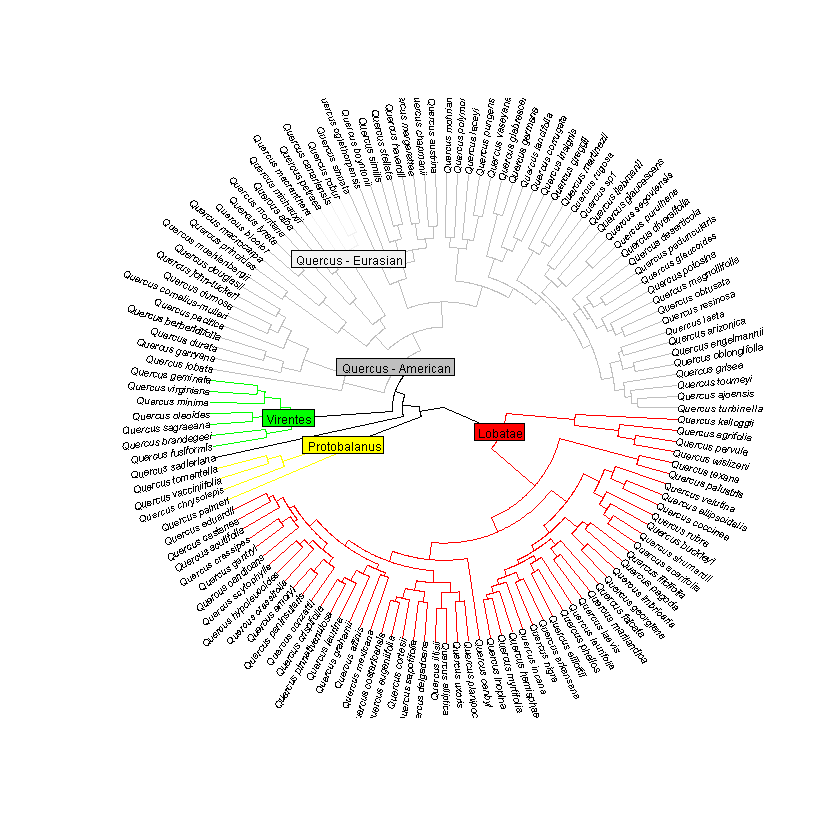

In [19]:
plot.phylo(tr, 'fan', show.tip.label = TRUE, edge.color = dat.sect.colVect, cex = 0.5)
nodelabels(text = names(dat.sect.mrca), node = dat.sect.mrca, cex = 0.6, bg = dat.sect.colors)

and just because it's easy, let's do a quick-and-dirty representation of the biogeographic data matrix. For this one, we'll use `ggtree`, which has a nice phylogenetic heatmap function:

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.


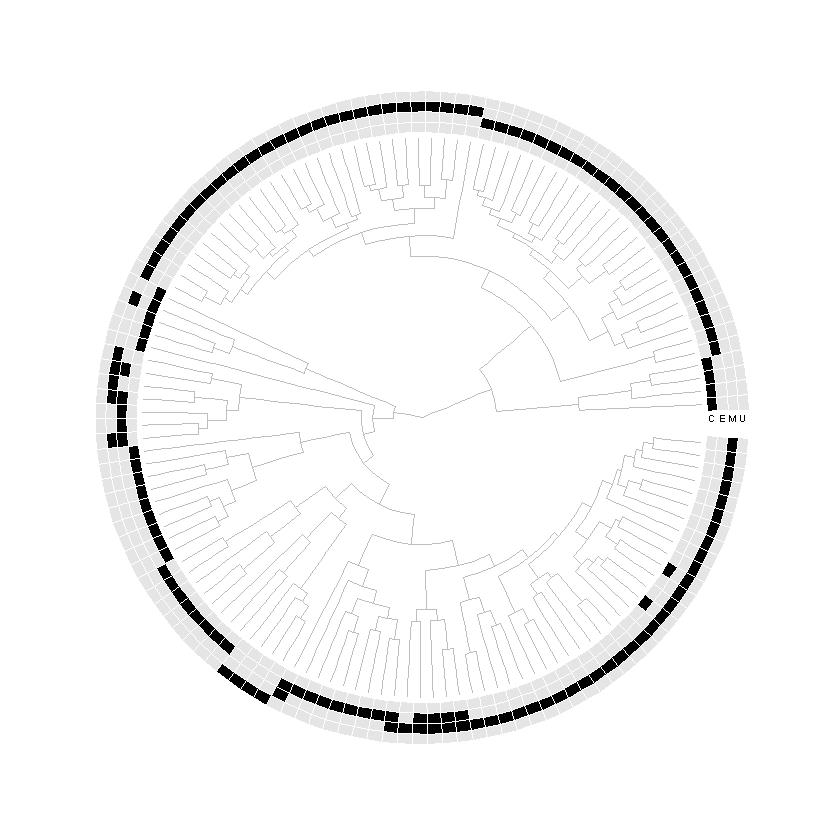

In [20]:
p <- ggtree(tr, 
            layout = 'fan', # makes a circular layout
            open.angle = 5, # leaves room for the labels
            colour = 'gray') # and makes the branches gray so they fade into the backgroun

dat.geog.cat <- dat.geog
for(i in 1:4) dat.geog.cat[[i]] <- factor(dat.geog.cat[[i]])
    
p <- gheatmap(p,
              dat.geog.cat,
             colnames_position = 'bottom',
             font.size = 2, 
             width = 0.15)

p <- p + scale_fill_manual(name = "Geographic region",
                            values = c('gray90', 'black'))

p <- p + theme(legend.position = 'none')

print(p)

### Visualizing multivariate data using ordination
The last thing we'll do is use ordination to inspect our data. With any data, visualization is important to understanding what your data are saying, both to tell the story and make sure the story you are telling makes sense. This first pair of PCAs shows us that in the data we are looking at, clades exhibit convergence in climatic and geographic space.

Warning message:
"The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them."Warning message:
"Removed 7 rows containing missing values (geom_point)."

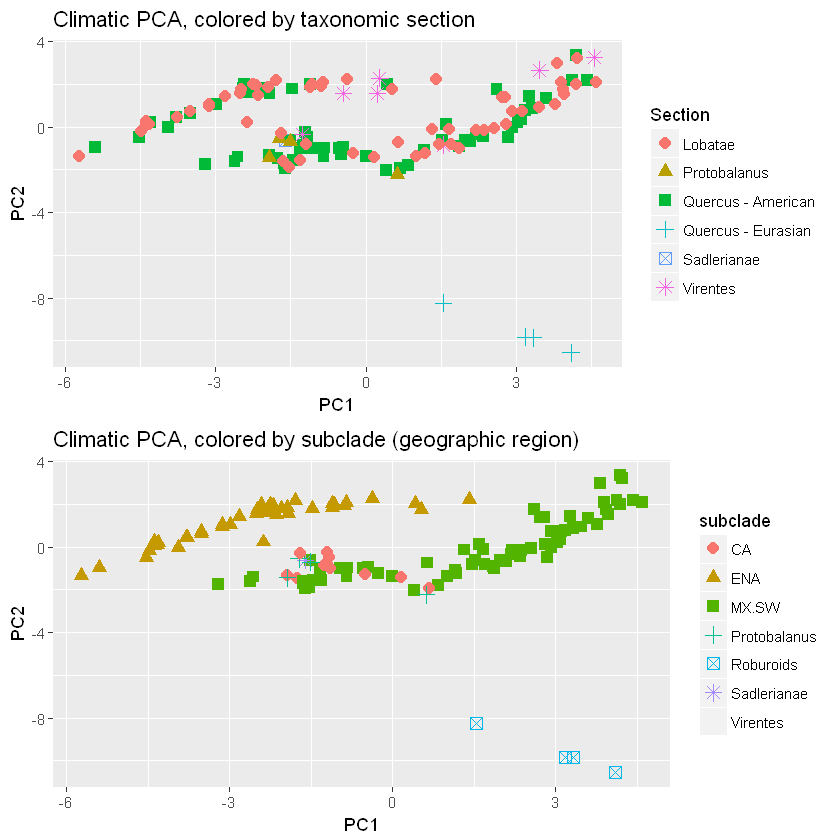

In [21]:
dat.pca <- prcomp(dat.bio.means[, grep('bio', dimnames(dat.bio.means)[[2]])], scale = T)
pc.dat <- as.data.frame(cbind(dat.pca$x, dat.sections[row.names(dat.pca$x), ]))

layout(matrix(1:2, 1))
p <- ggplot(pc.dat, aes(PC1, PC2))
#p1 <- p + scale_fill_manual(c('yellow', 'green', 'black', 'orange', 'gray10', 'gray30', 'gray50'))
p1 <- p + geom_point(aes(color = subclade, shape = subclade), size = 3)
p1 <- p1 + ggtitle('Climatic PCA, colored by subclade (geographic region)')

p2 <- p + geom_point(aes(color = Section, shape = Section), size = 3)
p2 <- p2 + ggtitle('Climatic PCA, colored by taxonomic section')

multiplot(p2, p1, ncol = 1)

Finally, we can wee these same data the tree overlaid to see how phylogenetic history plays out in ecological space:

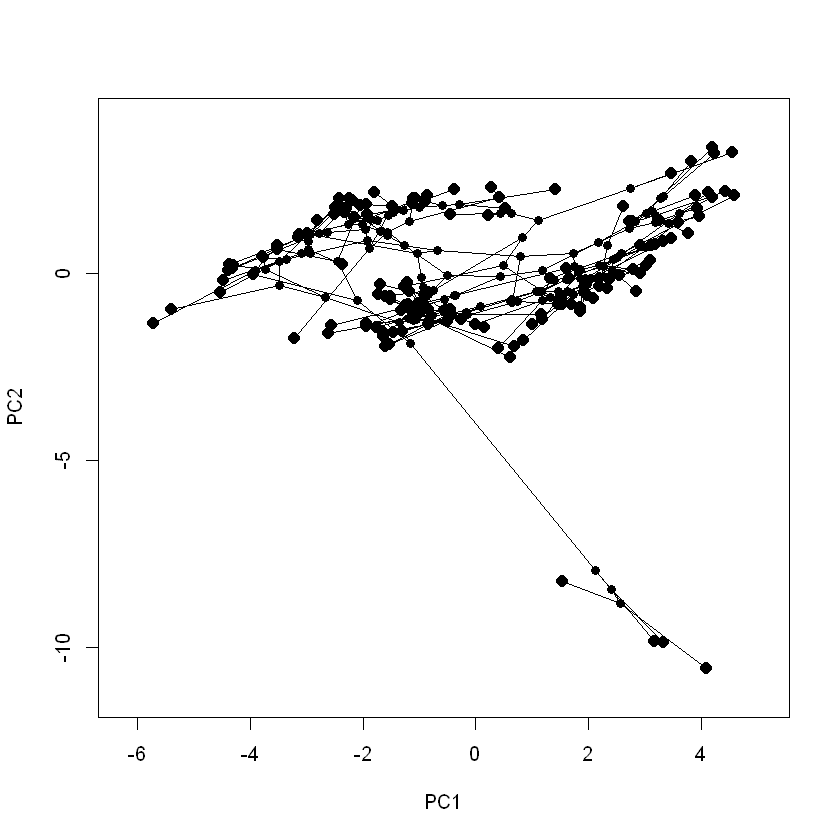

In [22]:
phylomorphospace(tr, dat.pca$x[, 1:2], label = "off")

### At the end of the day
Provided you have navigated to a new folder, you can end your session using "q()" or "quit()," and you'll be given the option to save your workspace. Do so: you'll find all your objects and history (up to 512 lines, unless you increase the default using "Sys.setenv(R_HISTSIZE = x)", where x is the number of lines you'd like to be saved in the history file). You can later double-click the workspace file if you are in windows or simply launch R from within the folder you've left (in Linux and, I think, Mac) to restore the worksession. Alternatively, you can reload it manually using "load(x)", where x is the name of your workspace. You can also save any objects you like in the workspace using "save"... see documentation for these.

In [23]:
save.image(file = '../../PCM.session01b.Rdata') # places this in the PCM tutorials folder

## Websites for additional information and examples
http://kembellab.ca/r-workshop/biodivR/SK_Biodiversity_R.html

http://www.mpcm-evolution.org/practice/online-practical-material-chapter-4/chapter-4-1-codes-used-produce-twelve-figures-chapter